In [1]:
import yfinance as yahoo
import pandas as pd
import numpy as np
import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
tech = ['AAPL','MSFT','INTC','QCOM','GLOB','IBM','ADBE','NVDA','CSCO','HPQ']

In [3]:
df = yahoo.download(tech,period="1y",interval="60m")['Adj Close'].fillna(method='ffill')
df = df.fillna(method='ffill')
start, end = df.iloc[0,:], df.iloc[-1,:]
renta = (end / start)
renta = renta.sort_values(axis=0,ascending=False)
renta

[*********************100%***********************]  10 of 10 completed


AAPL   NaN
ADBE   NaN
CSCO   NaN
GLOB   NaN
HPQ    NaN
IBM    NaN
INTC   NaN
MSFT   NaN
NVDA   NaN
QCOM   NaN
dtype: float64

In [4]:
df

,AAPL,ADBE,CSCO,GLOB,HPQ,IBM,INTC,MSFT,NVDA,QCOM
Datetime,,,,,,,,,,
2019-08-14 09:30:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-15 09:30:00-04:00,202.559998,283.355011,47.164101,100.349998,18.780001,131.350006,45.849998,133.395004,149.380005,71.959999
2019-08-15 10:30:00-04:00,201.270004,282.859985,46.945000,100.040604,18.670000,131.309998,45.840000,133.292694,148.270004,71.620003
2019-08-15 11:30:00-04:00,201.910004,282.589996,46.794998,100.370003,18.629999,131.559601,45.849998,133.580002,148.216797,71.129997
2019-08-15 12:30:00-04:00,202.100006,283.029999,46.505001,99.779999,18.639999,131.559998,45.820000,133.500000,148.919998,71.089996
...,...,...,...,...,...,...,...,...,...,...
2020-08-14 11:30:00-04:00,457.636902,446.549988,42.373199,175.505005,18.309999,125.239998,48.980000,208.479996,460.790009,113.809998
2020-08-14 12:30:00-04:00,459.140015,447.769989,42.470001,174.360001,18.334999,125.305000,49.055000,208.649994,460.795013,113.809998
2020-08-14 13:30:00-04:00,457.269989,446.690002,42.564999,175.529999,18.250000,125.280403,48.957500,208.610001,459.739990,113.595001


In [5]:
noa = len(df.columns) #number of assets
weights = np.random.random(noa)
weights /= np.sum(weights)
observations = len(df.index)
alpha = 0.05
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()

In [6]:
def calc_portfolio_VaR(weights, mean_returns, cov, alpha, observations):
    portfolio_return = np.sum(mean_returns * weights) * observations
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(observations)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_var

def min_VaR(mean_returns, cov, alpha, observations):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, alpha, observations)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (-0.3,0.3)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_VaR, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result


In [7]:
min_port_VaR = min_VaR(mean_returns, cov, alpha, observations)

minimal_VaR = pd.DataFrame(index=df.columns)
minimal_VaR['weigths'] = pd.DataFrame([round(x,3) for x in min_port_VaR['x']],index=df.columns)
minimal_VaR.weigths.sort_values(axis=0,ascending=False)

GLOB    0.134
NVDA    0.132
MSFT    0.132
AAPL    0.132
ADBE    0.130
QCOM    0.123
INTC    0.059
IBM     0.055
HPQ     0.054
CSCO    0.049
Name: weigths, dtype: float64

In [8]:
portfolio = (df * minimal_VaR.weigths).T.sum()

retorno = portfolio.pct_change().cumsum()

benchmark = df.T.mean() # build an equally weigthed portfolio to use as benchmark

assets_return = df.pct_change().cumsum() # spectrum of the assets returns


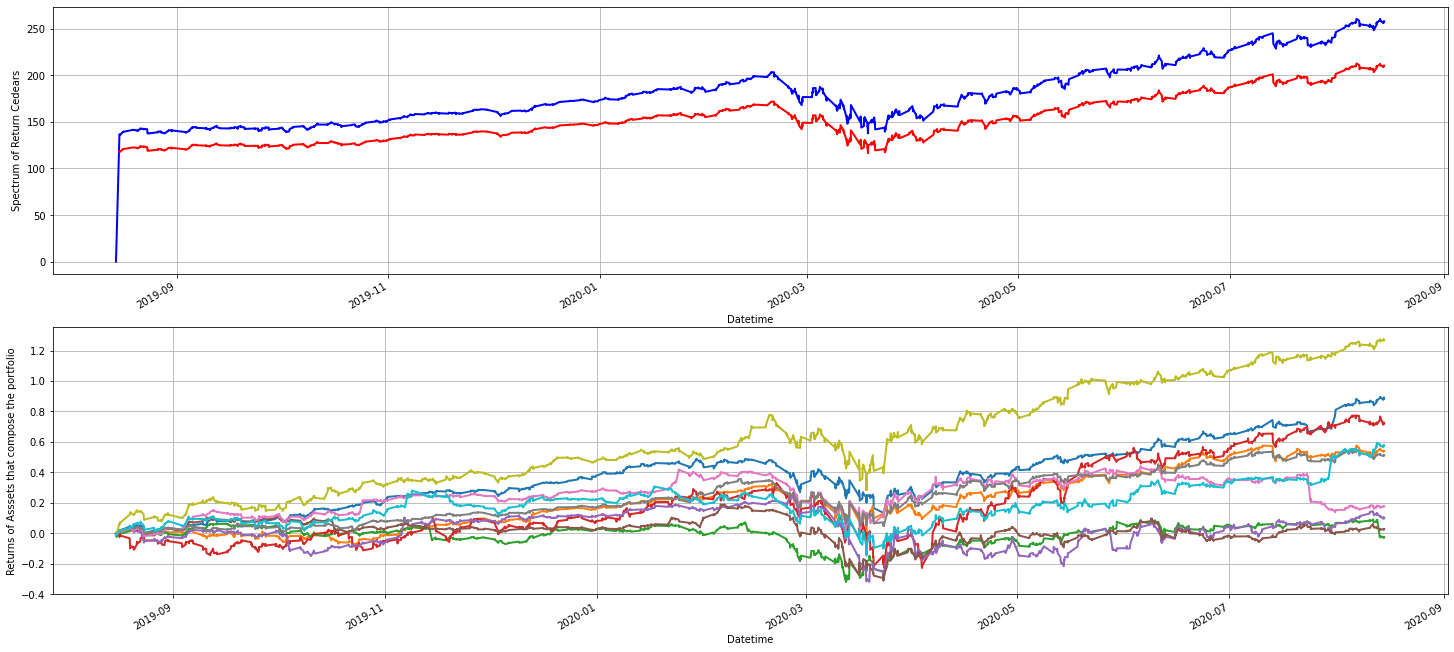

In [9]:
fig = plt.figure(figsize=(25,12))
ax1 = fig.add_subplot(211, ylabel='Spectrum of Return Cedears')
portfolio.plot(ax=ax1, color='b', lw=2.)
benchmark.plot(ax=ax1, color='r', lw=2.)
ax1.grid()
ax2 = fig.add_subplot(212, ylabel='Returns of Asssets that compose the portfolio')
assets_return.plot(ax=ax2, lw=2., legend=False)
ax2.grid()
plt.show()

In [10]:
portfolio, benchmark

(Datetime
 2019-08-14 09:30:00-04:00      0.000000
 2019-08-15 09:30:00-04:00    136.452913
 2019-08-15 10:30:00-04:00    135.955511
 2019-08-15 11:30:00-04:00    136.024470
 2019-08-15 12:30:00-04:00    136.089615
                                 ...    
 2020-08-14 11:30:00-04:00    257.162557
 2020-08-14 12:30:00-04:00    257.403331
 2020-08-14 13:30:00-04:00    256.994842
 2020-08-14 14:30:00-04:00    256.703719
 2020-08-14 15:30:00-04:00    257.754329
 Length: 1766, dtype: float64,
 Datetime
 2019-08-14 09:30:00-04:00           NaN
 2019-08-15 09:30:00-04:00    118.414412
 2019-08-15 10:30:00-04:00    118.011829
 2019-08-15 11:30:00-04:00    118.063140
 2019-08-15 12:30:00-04:00    118.094500
                                 ...    
 2020-08-14 11:30:00-04:00    209.767509
 2020-08-14 12:30:00-04:00    209.969001
 2020-08-14 13:30:00-04:00    209.648788
 2020-08-14 14:30:00-04:00    209.409851
 2020-08-14 15:30:00-04:00    210.215999
 Length: 1766, dtype: float64)

In [11]:
minimal_VaR = pd.DataFrame(index=df.columns)
minimal_VaR['weigths'] = pd.DataFrame([round(x,2) for x in min_port_VaR['x']],index=df.columns)
minimal_VaR.weigths.sort_values(axis=0,ascending=False)

NVDA    0.13
MSFT    0.13
GLOB    0.13
ADBE    0.13
AAPL    0.13
QCOM    0.12
INTC    0.06
IBM     0.05
HPQ     0.05
CSCO    0.05
Name: weigths, dtype: float64

In [12]:
portfolio = (df * minimal_VaR.weigths).T.sum()
portfolio

Datetime
2019-08-14 09:30:00-04:00      0.000000
2019-08-15 09:30:00-04:00    134.226107
2019-08-15 10:30:00-04:00    133.736378
2019-08-15 11:30:00-04:00    133.802514
2019-08-15 12:30:00-04:00    133.868150
                                ...    
2020-08-14 11:30:00-04:00    253.257206
2020-08-14 12:30:00-04:00    253.498951
2020-08-14 13:30:00-04:00    253.092818
2020-08-14 14:30:00-04:00    252.808046
2020-08-14 15:30:00-04:00    253.843599
Length: 1766, dtype: float64

In [13]:
data = df

# Calculate the returns of instruments, statistics & correlation
returns = (data - data.shift(1))/ data.shift(1)# get the returns for every serie

statistics = returns.describe().T

statistics['mad'] = returns.mad()

statistics['skew'] = returns.skew()

statistics['kurtosis'] = returns.kurtosis()

statistics = statistics.T

correlation = returns.corr() # correlation

covariance = returns.cov()  # covariance

# Calculate the deltas of the instruments as the weights assigned multiplied by their correlations (elasticity)
instruments = pd.DataFrame(index= data.columns)
instruments['weigths'] = 1/len(instruments.index) # secure allocation is equal 1
instruments['deltas'] = (instruments.weigths * correlation).sum() # deltas as elasticity of the assets
instruments['Stdev'] = returns.std()
instruments['stress'] = (instruments.deltas * instruments.Stdev) * 3 # stress applied at 4 deviations
instruments['portfolio_stress'] = instruments.stress.sum() # the stress of the portfolio

# Optional, if all the worst events happen at once, must detect the worst deviation of the instruments and apply it simultaneously
poe = (returns / returns.std()).min()
fullstress = sum(instruments.stress.multiply(poe))


In [14]:
instruments

,weigths,deltas,Stdev,stress,portfolio_stress
AAPL,0.1,0.700226,0.008929,0.018757,0.205344
ADBE,0.1,0.679186,0.009712,0.019789,0.205344
CSCO,0.1,0.616322,0.009301,0.017198,0.205344
GLOB,0.1,0.576448,0.013797,0.023860,0.205344
HPQ,0.1,0.546960,0.012074,0.019811,0.205344
IBM,0.1,0.647103,0.009062,0.017592,0.205344
INTC,0.1,0.647991,0.011213,0.021798,0.205344
MSFT,0.1,0.721893,0.008545,0.018506,0.205344
NVDA,0.1,0.673257,0.012721,0.025694,0.205344
QCOM,0.1,0.641562,0.011607,0.022340,0.205344


In [15]:
poe, fullstress

(AAPL   -11.555484
 ADBE   -12.253842
 CSCO   -12.407530
 GLOB    -7.842716
 HPQ     -9.985430
 IBM    -11.745598
 INTC   -14.106290
 MSFT   -11.161362
 NVDA    -9.302759
 QCOM   -11.416950
 dtype: float64,
 -2.272313229269625)

In [16]:
portfolio = data.T.mean()
portfolio

Datetime
2019-08-14 09:30:00-04:00           NaN
2019-08-15 09:30:00-04:00    118.414412
2019-08-15 10:30:00-04:00    118.011829
2019-08-15 11:30:00-04:00    118.063140
2019-08-15 12:30:00-04:00    118.094500
                                ...    
2020-08-14 11:30:00-04:00    209.767509
2020-08-14 12:30:00-04:00    209.969001
2020-08-14 13:30:00-04:00    209.648788
2020-08-14 14:30:00-04:00    209.409851
2020-08-14 15:30:00-04:00    210.215999
Length: 1766, dtype: float64

In [17]:
portfolio_returns = (portfolio - portfolio.shift(1))/ portfolio.shift(1)

portfolio_stats = portfolio_returns.describe(percentiles=[.01,.05,.10]).T

portfolio_stats['var'] = portfolio_returns.var()

portfolio_stats['skew'] = portfolio_returns.skew()

portfolio_stats['Kurtosis'] = portfolio_returns.kurtosis()

In [18]:
risk = pd.DataFrame(index=data.columns)
risk['numerator'] = (instruments.deltas.multiply(covariance)).sum()
risk['denominator'] = portfolio_returns.std() * (-2.32635) # at 1% of inverse normal dist.
risk['GradVaR'] = -risk.numerator / risk.denominator
risk['CVaRj'] = risk.GradVaR * instruments.deltas # Component VaR of the Risk Factors j
risk['thetai'] = (risk.CVaRj * correlation).sum() # Theta i of the instruments
risk['CVaRi'] = risk.thetai * (1/len(data.columns)) # Component VaR of the Instruments i
risk['totalCVaRi'] = risk.CVaRi.sum() #total CVaR of the portfolio
risk['CVaRattribution'] = risk.CVaRi / risk.totalCVaRi # risk allocation by instrument in the portfolio
risk

,numerator,denominator,GradVaR,CVaRj,thetai,CVaRi,totalCVaRi,CVaRattribution
AAPL,0.000461,-0.02038,0.022624,0.015842,0.110928,0.011093,0.096993,0.114366
ADBE,0.000474,-0.02038,0.023263,0.015800,0.107310,0.010731,0.096993,0.110636
CSCO,0.000369,-0.02038,0.018113,0.011163,0.068803,0.006880,0.096993,0.070936
GLOB,0.000499,-0.02038,0.024483,0.014113,0.081357,0.008136,0.096993,0.083879
HPQ,0.000387,-0.02038,0.018980,0.010381,0.056781,0.005678,0.096993,0.058542
IBM,0.000399,-0.02038,0.019574,0.012666,0.081965,0.008197,0.096993,0.084506
INTC,0.000500,-0.02038,0.024513,0.015884,0.102926,0.010293,0.096993,0.106117
MSFT,0.000469,-0.02038,0.023003,0.016606,0.119876,0.011988,0.096993,0.123592
NVDA,0.000617,-0.02038,0.030256,0.020370,0.137142,0.013714,0.096993,0.141393
QCOM,0.000509,-0.02038,0.024986,0.016030,0.102845,0.010284,0.096993,0.106033


In [19]:
cartera = pd.DataFrame(index=data.columns)
cartera['base'] = instruments.weigths
cartera['CVaRattribution'] = risk.CVaRattribution.sort_values(axis=0,ascending=False)
cartera['new'] = minimal_VaR.weigths
cartera['condition'] = (cartera.base  * cartera.CVaRattribution)
cartera['newrisk'] = (cartera.new  * cartera.CVaRattribution)
cartera['differences'] = (cartera.newrisk - cartera.condition)  # apply this result as a percentage to multiply new weights
cartera['adjustments'] = (cartera.newrisk - cartera.condition) / cartera.condition #ALARM if its negative sum up the difference, 
                                            #if it is positive rest it, you need to have 0
cartera['suggested'] = cartera.new * (1 + cartera.adjustments)   
cartera['tototal'] = cartera.suggested.sum()
cartera['MinCVaR'] = cartera.suggested / cartera.tototal
cartera

,base,CVaRattribution,new,condition,newrisk,differences,adjustments,suggested,tototal,MinCVaR
AAPL,0.1,0.114366,0.13,0.011437,0.014868,0.003431,0.3,0.169,1.1,0.153636
ADBE,0.1,0.110636,0.13,0.011064,0.014383,0.003319,0.3,0.169,1.1,0.153636
CSCO,0.1,0.070936,0.05,0.007094,0.003547,-0.003547,-0.5,0.025,1.1,0.022727
GLOB,0.1,0.083879,0.13,0.008388,0.010904,0.002516,0.3,0.169,1.1,0.153636
HPQ,0.1,0.058542,0.05,0.005854,0.002927,-0.002927,-0.5,0.025,1.1,0.022727
IBM,0.1,0.084506,0.05,0.008451,0.004225,-0.004225,-0.5,0.025,1.1,0.022727
INTC,0.1,0.106117,0.06,0.010612,0.006367,-0.004245,-0.4,0.036,1.1,0.032727
MSFT,0.1,0.123592,0.13,0.012359,0.016067,0.003708,0.3,0.169,1.1,0.153636
NVDA,0.1,0.141393,0.13,0.014139,0.018381,0.004242,0.3,0.169,1.1,0.153636
QCOM,0.1,0.106033,0.12,0.010603,0.012724,0.002121,0.2,0.144,1.1,0.130909


In [20]:
propuesta = data * cartera.MinCVaR
propuesta = propuesta.T.sum()

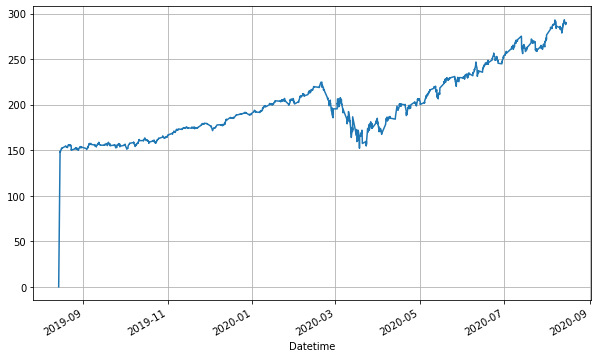

In [21]:
p = propuesta.plot(figsize=(10,6))
p.grid()

In [22]:
propuesta

Datetime
2019-08-14 09:30:00-04:00      0.000000
2019-08-15 09:30:00-04:00    148.920868
2019-08-15 10:30:00-04:00    148.359611
2019-08-15 11:30:00-04:00    148.440567
2019-08-15 12:30:00-04:00    148.529886
                                ...    
2020-08-14 11:30:00-04:00    289.431419
2020-08-14 12:30:00-04:00    289.707461
2020-08-14 13:30:00-04:00    289.234084
2020-08-14 14:30:00-04:00    288.910700
2020-08-14 15:30:00-04:00    290.126908
Length: 1766, dtype: float64

In [23]:
ponderaciones = cartera.MinCVaR.sort_values(axis=0,ascending=False)
ponderaciones.head(10)

GLOB    0.153636
NVDA    0.153636
MSFT    0.153636
ADBE    0.153636
AAPL    0.153636
QCOM    0.130909
INTC    0.032727
IBM     0.022727
HPQ     0.022727
CSCO    0.022727
Name: MinCVaR, dtype: float64